## Import the needed libraries

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
import time 

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from sklearn.preprocessing import normalize

# Audio
import sounddevice as sd
from scipy.io import wavfile
import librosa

# Visualization
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import seaborn as sns

#Neuronal networks
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.models import Sequential,load_model
import keras
import utils

Using TensorFlow backend.


## Convert MP3 to WAV

All tracks should be change to wav format in order to work easily whit python

In [2]:
path = '.\\data\\fma_small'
#utils.all_mp3_to_wav(path)

## Read metadata

In [3]:
AUDIO_DIR='.\\data\\fma_small'
META_DIR='.\\data\\fma_metadata'

features = utils.load(META_DIR+'\\features.csv')
echonest = utils.load(META_DIR+'\\echonest.csv')
genres = utils.load(META_DIR+'\\genres.csv')
tracks = utils.load(META_DIR+'\\tracks.csv')
#raw_tracks = utils.load(META_DIR+'\\raw_tracks.csv')
artists = utils.load(META_DIR+'\\raw_artists.csv')



C:\Users\User_01\Documents\Master\DeepLearning\Proyecto\fma\utils.py:232: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  'category', categories=SUBSETS, ordered=True)


## Get small subset of data

In [4]:
# Creating the subset 
small = tracks[tracks['set', 'subset'] <= 'small']

# Splitind song IDs by train/test/validation
ids_train = small[small['set', 'split'] == 'training'].index
ids_test = small[small['set', 'split'] == 'test'].index
ids_validation = small[small['set', 'split'] == 'validation'].index

## Explore features of tracks using an arbitrary example

In [5]:
import time
time.sleep(3)

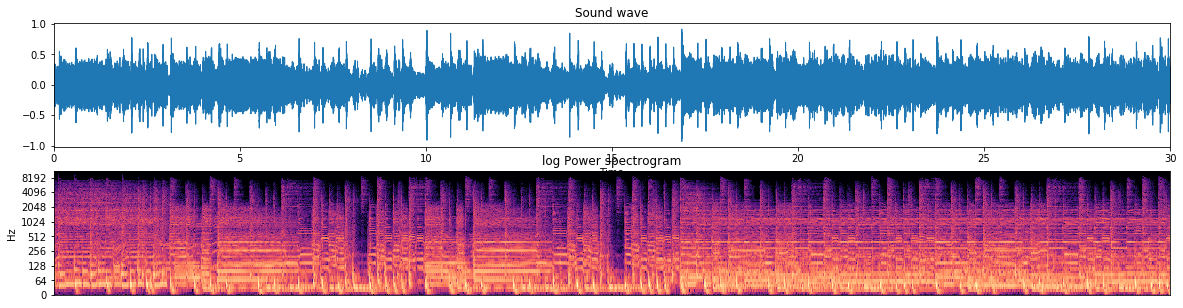

In [6]:
# Getting an arbitrary example
tid_example = 122077
filepath = utils.get_audio_path(AUDIO_DIR,tid_example)
example, sr = librosa.load(filepath, sr=None, mono=True)
example_S, phase = librosa.magphase(librosa.stft(example)) 

#Plotting representation of the track
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.title('Sound wave')
librosa.display.waveplot(example, sr=sr)
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(example_S, ref=np.max), y_axis='log')
plt.title('log Power spectrogram')
plt.show()

#sd.play(example, sr)
#time.sleep(5)
sd.stop()


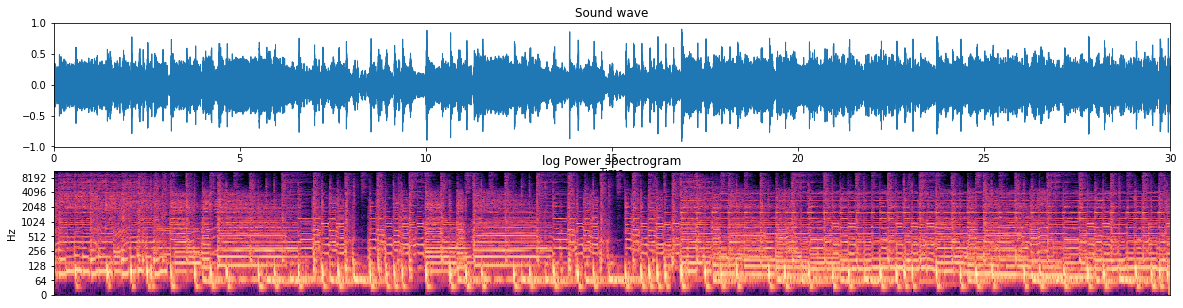

In [7]:
# Resampling with half of the sample rate
example, sr = librosa.load(filepath, sr=24000, mono=True,duration =30)
example_S, phase = librosa.magphase(librosa.stft(example)) 

#Plotting representation of the track
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.title('Sound wave')
librosa.display.waveplot(example, sr=sr)
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(example_S, ref=np.max), y_axis='log')
plt.title('log Power spectrogram')
plt.show()

#sd.play(example, sr)
#time.sleep(5)
sd.stop()


### Constant-Q chromagram, Chroma Energy Normalized y stft Chornogram
#### Explanation:
https://en.wikipedia.org/wiki/Constant-Q_transform 
https://labrosa.ee.columbia.edu/matlab/chroma-ansyn/

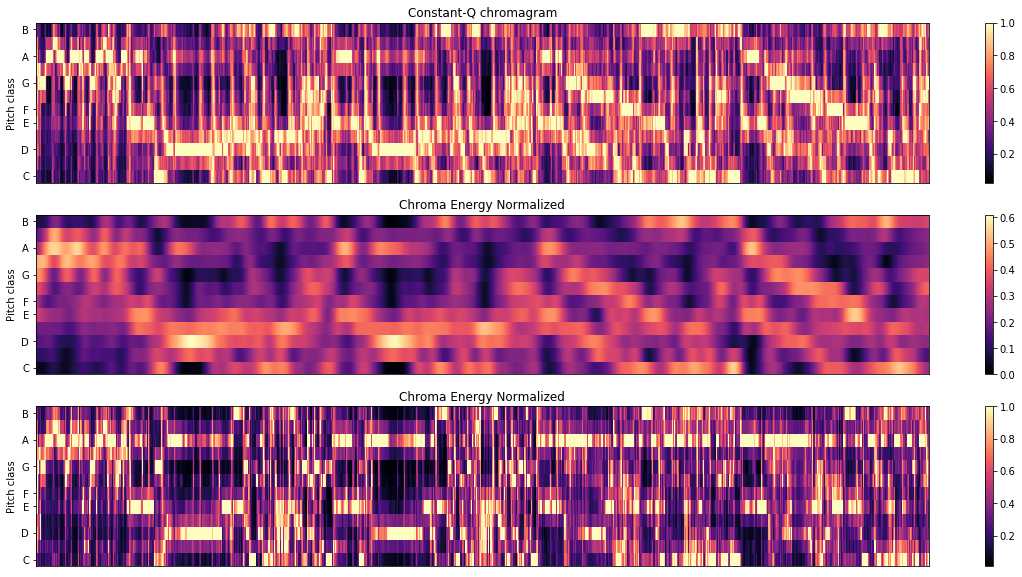

In [8]:
chroma_cq   = librosa.feature.chroma_cqt(y=example, sr=sr)
chroma_cens = librosa.feature.chroma_cens(y=example, sr=sr)
chroma_stft = librosa.feature.chroma_stft(y=example, sr=sr)

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
librosa.display.specshow(chroma_cq, y_axis='chroma')
plt.title('Constant-Q chromagram')
plt.colorbar()
plt.subplot(3,1,2)
librosa.display.specshow(chroma_cens, y_axis='chroma')
plt.title('Chroma Energy Normalized')
plt.colorbar()
plt.subplot(3,1,3)
librosa.display.specshow(chroma_stft, y_axis='chroma')
plt.title('Chroma Energy Normalized')
plt.colorbar()
plt.show()

### Root Mean Square (RMS) energy 
#### Explanation:
https://en.wikipedia.org/wiki/Root_mean_square

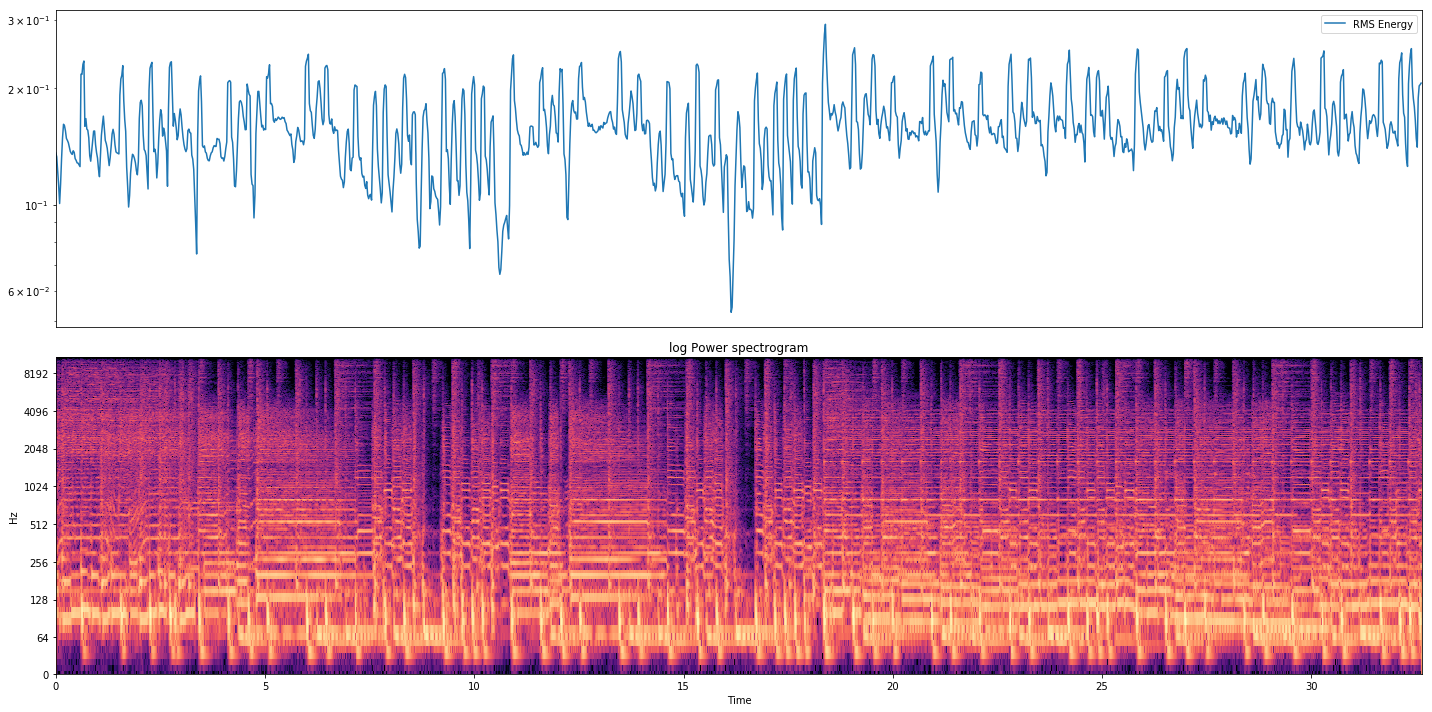

In [9]:
rmse =  librosa.feature.rmse(y=example)


plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.semilogy(rmse.T, label='RMS Energy')
plt.xticks([])
plt.xlim([0, rmse.shape[-1]])
plt.legend(loc='best')
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(example_S, ref=np.max),  y_axis='log', x_axis='time')
plt.title('log Power spectrogram')
plt.tight_layout()

### spectral_centroid spectral_bandwidth spectral_contrast spectral_rolloff
#### Explanation:
https://en.wikipedia.org/wiki/Roll-off


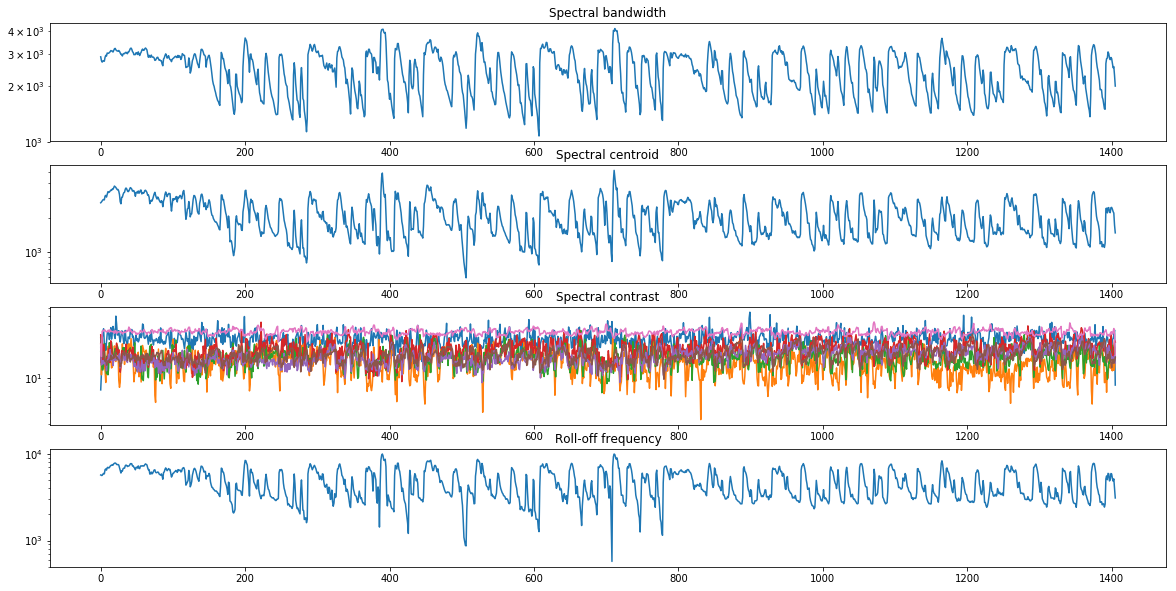

In [10]:
bandwidth = librosa.feature.spectral_bandwidth(y=example, sr=sr)
centroid  = librosa.feature.spectral_centroid(y=example, sr=sr)
contrast  = librosa.feature.spectral_contrast(y=example, sr=sr, n_bands=6)
rolloff   = librosa.feature.spectral_rolloff(y=example, sr=sr)

plt.figure(figsize=(20,10)) 
plt.subplot(4,1,1)
plt.semilogy(bandwidth.T)
plt.title('Spectral bandwidth')
  
plt.subplot(4,1,2)
plt.semilogy(centroid.T)
plt.title('Spectral centroid')

plt.subplot(4,1,3)
plt.semilogy(contrast.T)
plt.title('Spectral contrast')

plt.subplot(4,1,4)
plt.semilogy(rolloff.T)
plt.title('Roll-off frequency')
plt.show()


### Mel Frequency Cepstral Coeﬃcients
#### Explanation:
https://en.wikipedia.org/wiki/Mel_scale
https://es.wikipedia.org/wiki/MFCC

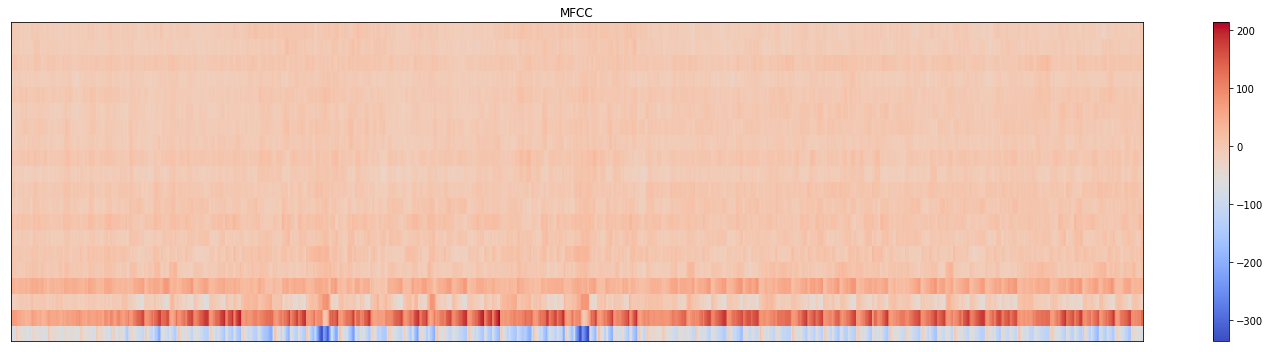

In [11]:
mfcc = librosa.feature.mfcc(y=example, sr=sr,n_mfcc =20)

plt.figure(figsize=(20,5))
librosa.display.specshow(mfcc)
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

### Preparation of data

In [12]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [13]:
freqs, times, spectrogram = log_specgram(example,sr)

In [14]:
## Commented cause it fails in someway 
#fig = plt.figure(figsize=(14, 8))
#ax1 = fig.add_subplot(211)
#ax1.set_ylabel('Amplitud')
#ax1.plot(np.linspace(0, sr/len(example), sr), example)
#
#ax2 = fig.add_subplot(212)
#ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
#           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
#ax2.set_yticks(freqs[::16])
#ax2.set_xticks(times[::16])
#ax2.set_ylabel('Frecuencias en Hz')
#ax2.set_xlabel('Segundos')
#plt.show()

# Fully connected network

In [15]:
# merging genres with features
features_2_level = features.copy()
features_2_level.columns = features_2_level.columns.droplevel(2)
tracks_features = np.array(pd.merge(tracks['track','genre_top'].to_frame(), features_2_level, left_index=True, right_index=True).values)



In [16]:
# Taking 8 main genres
top_genres = pd.unique(small['track','genre_top'])
number_of_top_genders=len(top_genres)
top_genred_features = tracks_features[np.isin(tracks_features[:,0],top_genres)]

In [17]:
# Oneshot genres
def one_shot_genre(genre,list_genre):
    return 1*np.array(list_genre == genre)

        

genre_oneshot = []
for genre in top_genred_features[:,0]:
    genre_oneshot.append(one_shot_genre(genre,top_genres ))
    

final_data = np.concatenate((top_genred_features,genre_oneshot),axis=1)

In [18]:
# Preparing train and test data
TRAIN_PERCENTAGE=0.7

np.random.shuffle(final_data)

x_train = normalize(final_data[:int(final_data.shape[0]*TRAIN_PERCENTAGE),1:-len(top_genres)],axis=0)
y_train = final_data[:int(final_data.shape[0]*TRAIN_PERCENTAGE),-number_of_top_genders:]

x_test = normalize(final_data[int(final_data.shape[0]*TRAIN_PERCENTAGE):,1:-len(top_genres)],axis=0)
y_test = final_data[int(final_data.shape[0]*TRAIN_PERCENTAGE):,-number_of_top_genders:]


In [19]:
# modelo
HIDDEN_SIZE_L1=32
HIDDEN_SIZE_L2=32

model = Sequential()
model.add(Dense(HIDDEN_SIZE_L1, activation='tanh',input_dim=np.shape(x_train)[1]))
model.add(Dense(HIDDEN_SIZE_L2, activation='tanh'))
model.add(Dense(number_of_top_genders, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                16608     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
Total params: 17,928
Trainable params: 17,928
Non-trainable params: 0
_________________________________________________________________


In [20]:
# training model

BATCH_SIZE = 64
n_iteraciones = 100
for iteracion in range(1, n_iteraciones+1):
    print()
    print('-' * 50)
    print('Iteracion %d de %d' % (iteracion, n_iteraciones))
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=10,
              validation_data=(x_test, y_test))


--------------------------------------------------
Iteracion 1 de 100
Train on 32421 samples, validate on 13896 samples
Epoch 1/10
32421/32421 [==============================] - 2s 56us/step - loss: 0.3531 - acc: 0.8743 - val_loss: 0.3131 - val_acc: 0.8786
Epoch 2/10
32421/32421 [==============================] - 1s 35us/step - loss: 0.2890 - acc: 0.8893 - val_loss: 0.2741 - val_acc: 0.8944
Epoch 3/10
32421/32421 [==============================] - 1s 30us/step - loss: 0.2681 - acc: 0.8968 - val_loss: 0.2641 - val_acc: 0.8985
Epoch 4/10
32421/32421 [==============================] - 1s 28us/step - loss: 0.2595 - acc: 0.9000 - val_loss: 0.2610 - val_acc: 0.8994
Epoch 5/10
32421/32421 [==============================] - 1s 28us/step - loss: 0.2537 - acc: 0.9021 - val_loss: 0.2543 - val_acc: 0.9031
Epoch 6/10
32421/32421 [==============================] - 1s 32us/step - loss: 0.2489 - acc: 0.9041 - val_loss: 0.2499 - val_acc: 0.9049
Epoch 7/10
32421/32421 [==============================] -

32421/32421 [==============================] - 1s 27us/step - loss: 0.2007 - acc: 0.9238 - val_loss: 0.2813 - val_acc: 0.8943
Epoch 6/10
32421/32421 [==============================] - 1s 27us/step - loss: 0.2003 - acc: 0.9238 - val_loss: 0.2647 - val_acc: 0.8983
Epoch 7/10
32421/32421 [==============================] - 1s 28us/step - loss: 0.2002 - acc: 0.9240 - val_loss: 0.2945 - val_acc: 0.8884
Epoch 8/10
32421/32421 [==============================] - 1s 28us/step - loss: 0.2000 - acc: 0.9241 - val_loss: 0.2690 - val_acc: 0.8985
Epoch 9/10
32421/32421 [==============================] - 1s 28us/step - loss: 0.1996 - acc: 0.9243 - val_loss: 0.2952 - val_acc: 0.8897
Epoch 10/10
32421/32421 [==============================] - 1s 27us/step - loss: 0.1997 - acc: 0.9245 - val_loss: 0.2834 - val_acc: 0.8920

--------------------------------------------------
Iteracion 7 de 100
Train on 32421 samples, validate on 13896 samples
Epoch 1/10
32421/32421 [==============================] - 1s 27us/s

KeyboardInterrupt: 

In [21]:
# Evaluation of the network
loss_train, score_train = model.evaluate(x_train,y_train, verbose=0)
loss_val, score_val = model.evaluate(x_test,y_test, verbose=0)
print()
print("Loss  in training  :", loss_train)
print("Score in training  :", score_train)
print()
print("Loss  in validation:", loss_val)
print("Score in validation:", score_val)


Loss  in training  : 0.19424145536536935
Score in training  : 0.9261281268350516

Loss  in validation: 0.3074212962087023
Score in validation: 0.8857674870466321


# Recurrent netwok

In [151]:
# Get sound feature mfcc from
N_MAX_EXAMPLES=20
x_mfcc_train = []
y_mfcc_train = []
i=0

id_small_train = small[small['set','split'] == 'training']
for id_track in id_small_train.index.values:
    # Get file 
    filepath = utils.get_audio_path(AUDIO_DIR,id_track)
    # Get X_train
    example, sr = librosa.load(filepath, sr=None, mono=True,duration=30)
    mfcc = librosa.feature.mfcc(y=example, sr=sr,n_mfcc =10)
    mfcc_truncate = []
    for l in range(len(mfcc)):
        mfcc_truncate.append(mfcc[l,:2853])
    mfcc = np.reshape(np.array(mfcc_truncate,(10,2582))
    x_mfcc_train.append(mfcc)
    # Get Y_train
    label_oneshot = one_shot_genre(small.loc[id_track]['track','genre_top'],top_genres)
    y_mfcc_train.append(label_oneshot)    
    i+=1
    if i %100 == 0:
        print(i)
    if i%N_MAX_EXAMPLES == 0:
        break # My disc is very slow. I get only N_MAX_EXAMPLES song as a example to make te network

x_mfcc_train =  np.array(x_mfcc_train)
y_mfcc_train =  np.array(y_mfcc_train)

ValueError: cannot reshape array of size 25840 into shape (10,2582)

In [149]:
mask = np.ones(shape=(3,3))
mask[0] = np.resize(mask[0],(2))
mask

ValueError: could not broadcast input array from shape (2) into shape (3)

In [ ]:
# Get test
x_mfcc_test = []
y_mfcc_test = []
i=0
# Decreased sr because performance issues

id_small_test = small[small['set','split'] == 'test']
for id_track in id_small_test.index.values:
    # Get file 
    filepath = utils.get_audio_path(AUDIO_DIR,id_track)
    # Get X_train
    example, sr = librosa.load(filepath, sr=None, mono=True,duration =30)
    mfcc = librosa.feature.mfcc(y=example, sr=sr,n_mfcc =10)
    x_mfcc_test.append(mfcc)
    # Get Y_train
    label_oneshot = one_shot_genre(small.loc[id_track]['track','genre_top'],top_genres)
    y_mfcc_test.append(label_oneshot)  
    i+=1
    if i %100 == 0:
        print(i)
        break # My disc is very slow. I get only 100 song as a example to make te network

x_mfcc_test = np.array(x_mfcc_test)
y_mfcc_test = np.array(y_mfcc_test)

In [ ]:
# Definiing LSTM Network 

mi_optimizer = optimizers.adam(lr=0.0025)
n_hidden = 32
n_classes = y_fmcc_train.shape[1]
n_steps = x_fmcc_train.shape[1]
RNN = layers.LSTM
model = Sequential()
model.add(RNN(n_hidden,
              input_shape=(128,x_mfcc_train.shape[2]),
              return_sequences=True))

model.add(RNN(n_hidden))

model.add(layers.Dense(n_classes, activation="softmax"))
model.compile(loss="categorical_crossentropy",
              optimizer=mi_optimizer,metrics=['accuracy'])

model.summary()